# Exploring topic modeling

This Jupyter notebook should give you a running start on this week's homework. It reflects where we were at the end of class on Monday. Note that *you do not have to use this*! If you already have a running start on the problem, go ahead and use whatever notebook you're working in. But if you're struggling with some of the early steps, this may help.

If you do use this notebook as a starting point, please feel free to delete my explanatory prose (the description of the assignment, etc) from the notebook, so the .pdf you finally hand in can move rapidly to your own code.

As always, we start by importing some useful modules.

Note especially the addition of "%matplotlib inline." That command isn't strictly necessary, but it can make it a little smoother to display graphics in a Jupyter notebook.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path
import seaborn as sns
import re
from collections import Counter

%matplotlib inline

Now let's get our movie dataset. Note that if you move this notebook, you may need to change the path in the cell below. It's a *relative path*, which reflects the path from this notebook to the data in the GitHub repository.

In [9]:
dialogpath = Path('../data/movie_dialogue.tsv')
chars = pd.read_csv(dialogpath, sep = '\t')
chars.head()

,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines
0,m0,u0,BIANCA,10 things i hate about you,f,959,1999,"['comedy', 'romance']",True,False,False,True,They do not! / I hope so. / Let's go. / Okay -...
1,m0,u2,CAMERON,10 things i hate about you,m,527,1999,"['comedy', 'romance']",True,False,False,True,"They do to! / She okay? / Wow / No / The ""real..."
2,m0,u4,JOEY,10 things i hate about you,m,278,1999,"['comedy', 'romance']",True,False,False,True,"Listen, I want to talk to you about the prom. ..."
3,m0,u5,KAT,10 things i hate about you,f,1217,1999,"['comedy', 'romance']",True,False,False,True,Perm? / It's just you. / What? To completely d...
4,m0,u6,MANDELLA,10 things i hate about you,f,157,1999,"['comedy', 'romance']",True,False,False,True,William - he asked me to meet him here. / Have...


### Reading in the doc-topics file.

Note that this code assumes you've put your doctopics file in the data folder of the repo and named it ```character_doctopics.csv.``` It also assumes that this notebook (the one we're in right now) is in the homeworks folder. If you've moved either file or named the doctopics file differently, you will need to edit the path below.

Also, my instructions for generating the header assume that your doctopics file has 40 columns. If you used a different number of topics you'll need to edit the ```range(40)```.

In [7]:
header = ['charid']
header.extend(['topic' + str(x) for x in range(40)])   # There's no header in the doctopics file, so we need to create one.

doctopicpath = Path('../data/character_doctopics.csv')
doctopics = pd.read_csv(doctopicpath, header = None, names = header) # 
doctopics.head()

,charid,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,...,topic30,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39
0,u2074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,...,0.064516,0.000000,0.000000,0.00000,0.096774,0.000000,0.000000,0.096774,0.193548,0.000000
1,u980,0.033898,0.000000,0.050847,0.062954,0.000000,0.116223,0.135593,0.002421,0.000000,...,0.012107,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.048426,0.000000,0.004843
2,u976,0.062147,0.000000,0.005650,0.005650,0.000000,0.050847,0.000000,0.000000,0.022599,...,0.016949,0.000000,0.000000,0.00565,0.000000,0.000000,0.000000,0.000000,0.000000,0.045198
3,u2485,0.000000,0.070352,0.000000,0.000000,0.000000,0.070352,0.005025,0.000000,0.000000,...,0.000000,0.037688,0.000000,0.00000,0.000000,0.002513,0.002513,0.000000,0.002513,0.160804
4,u2487,0.000000,0.125984,0.000000,0.055118,0.007874,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.023622,0.094488,0.03937,0.000000,0.086614,0.000000,0.000000,0.000000,0.023622


### The assignment itself

**Homework 5, due Sunday March 7 at noon,** is exactly the same as our lab assignment today:

That is, take the movie-dialogue dataset we've been using, topic model it using Mimno's jsLDA, and choose a topic you'd like to understand better. Download the keys and the doc-topics matrix from your model, and use that data to illuminate your chosen topic by sharing:

a) The most prominent words in the topic, as reported by keys.csv.

b) A list of ten movies whose characters (on average) have the highest proportion of words allocated to that topic. Note that you can treat each character in a movie as making an equal contribution to the mean prominence of the topic in the movie, even though we know some say more than others.

c) A lineplot or scatterplot displaying the mean prominence of your chosen topic in characters from a given release-year.

d) Write a short paragraph at the end describing what—if anything—you think we learn about movie dialogue from the distribution of this topic across the dataset.

Alternatively, if you're already comfortable with gensim and want to do all of the above inside Python using gensim, you can do the assignment that way instead of using jsLDA.

### In order to address parts (b) and (c) of the assignment

we will need to join some data from the ```chars``` dataset to the doctopic dataset.

There are several ways to do this. Here's one:

In [10]:
if 'cid' in chars.columns:
    chars = chars.set_index('cid')
doctopics = doctopics.join(chars.loc[ : , ['mname', 'year']], on = 'charid')
doctopics.head()

,charid,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,mname,year
0,u2074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,...,0.000000,0.00000,0.096774,0.000000,0.000000,0.096774,0.193548,0.000000,metropolis,1927
1,u980,0.033898,0.000000,0.050847,0.062954,0.000000,0.116223,0.135593,0.002421,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.048426,0.000000,0.004843,frankenstein,1931
2,u976,0.062147,0.000000,0.005650,0.005650,0.000000,0.050847,0.000000,0.000000,0.022599,...,0.000000,0.00565,0.000000,0.000000,0.000000,0.000000,0.000000,0.045198,frankenstein,1931
3,u2485,0.000000,0.070352,0.000000,0.000000,0.000000,0.070352,0.005025,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.002513,0.002513,0.000000,0.002513,0.160804,platinum blonde,1931
4,u2487,0.000000,0.125984,0.000000,0.055118,0.007874,0.000000,0.000000,0.000000,0.000000,...,0.094488,0.03937,0.000000,0.086614,0.000000,0.000000,0.000000,0.023622,platinum blonde,1931


### A "solution" to part (c) that doesn't actually solve it

When I say that you want to visualize the *mean* prominence of your chosen topic in characters from a given year, note that plotting the mean is different from plotting all the characters individually. We can easily plot the proportion of words in each character's dialogue assigned to a particular topic:

<AxesSubplot:xlabel='year', ylabel='topic9'>

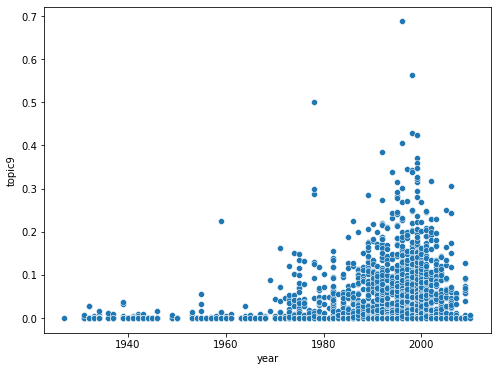

In [11]:
plt.figure(figsize = (8, 6))
sns.scatterplot(x = doctopics['year'], y = doctopics['topic9'])

At first glance it looks like the prominence of topic 9 is increasing. But the image is difficult to interpret, because we also have *more* characters toward the end of the timeline, and dots are overlapping. It's not immediately clear how much the average prominence of topic 9 actually increases.

Instead you're going to need to aggregate the characters by year, and take the mean for each year.